### Dataset ready

In [2]:
import pandas as pd
import random
import uuid
import math
from faker import Faker

fake = Faker("en_IN")

STATES = [
    "Maharashtra","Delhi","Tamil Nadu","Uttar Pradesh","Gujarat",
    "Karnataka","Rajasthan","West Bengal","Punjab","Haryana",
    "Telangana","Andhra Pradesh","Chhattisgarh","Odisha","Bihar",
    "Jharkhand","Assam","Goa","Manipur","Meghalaya","Mizoram",
    "Nagaland","Sikkim","Tripura"
]

DISPUTE_TYPES = [
    "invoice_non_payment",
    "interest_on_delay",
    "goods_rejection",
    "short_payment",
    "service_non_payment",
    "others"
]

DOCUMENTS = [
    "invoice",
    "purchase_order",
    "delivery_challan",
    "email_correspondence"
]

# Simulate state efficiency factor (legal speed index)
STATE_EFFICIENCY = {state: random.uniform(0.8, 1.2) for state in STATES}

def sigmoid(x):
    return 1 / (1 + math.exp(-x))

def generate_case():

    claim = round(random.uniform(50_000, 5_000_000), 2)
    delay_days = random.randint(30, 800)
    docs = random.sample(DOCUMENTS, k=random.randint(1, 4))
    doc_score = round(len(docs) / 4, 2)
    dispute_type = random.choice(DISPUTE_TYPES)
    jurisdiction = random.choice(STATES)

    # Latent opponent cooperation factor
    cooperation_factor = random.uniform(-1, 1)

    # --- Domain-Driven Scoring ---

    score = 0

    # Claim effect (small claims settle faster)
    if claim < 500_000:
        score += 1.5
    elif claim < 2_000_000:
        score += 0.5
    else:
        score -= 1

    # Delay effect (longer delay increases pressure)
    if delay_days > 365:
        score += 2
    elif delay_days > 180:
        score += 1

    # Documentation strength
    score += doc_score * 2

    # Dispute type effect
    if dispute_type in ["invoice_non_payment", "service_non_payment"]:
        score += 1.5
    elif dispute_type == "goods_rejection":
        score -= 1

    # Jurisdiction efficiency
    score *= STATE_EFFICIENCY[jurisdiction]

    # Add cooperation randomness
    score += cooperation_factor

    # Convert score to probability
    settlement_probability = sigmoid(score - 2)

    is_settlement = 1 if random.random() < settlement_probability else 0

    # Determine final outcome
    if is_settlement:
        outcome = "settlement"
        settle_min = round(random.uniform(0.65, 0.85), 2)
        settle_max = round(random.uniform(settle_min, 0.95), 2)
    else:
        outcome = random.choices(
            ["award_in_favor", "rejected", "pending"],
            weights=[0.4, 0.3, 0.3]
        )[0]
        settle_min = None
        settle_max = None

    return {
        "case_id": f"SYN_{uuid.uuid4().hex[:10]}",
        "dispute_type": dispute_type,
        "claim_amount": claim,
        "delay_days": delay_days,
        "document_count": len(docs),
        "document_completeness_score": doc_score,
        "jurisdiction": jurisdiction,
        "final_outcome": outcome,
        "settlement_min_ratio": settle_min,
        "settlement_max_ratio": settle_max,
        "is_settlement": is_settlement
    }


# Generate dataset
N = 200000
data = [generate_case() for _ in range(N)]

with open("msme_synthetic_cases.json", "w") as f:
    import json
    json.dump(data, f, indent=2)

print("✅ Improved dataset generated:", len(data))


✅ Improved dataset generated: 200000


# Traiing cell

In [2]:
import json
import joblib
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, classification_report
from xgboost import XGBClassifier

# Load JSON
with open("msme_synthetic_cases.json") as f:
    data = json.load(f)

df = pd.DataFrame(data)

# Encode categorical fields
dispute_encoder = LabelEncoder()
state_encoder = LabelEncoder()
df["dispute_type_enc"] = dispute_encoder.fit_transform(df["dispute_type"])
df["jurisdiction_enc"] = state_encoder.fit_transform(df["jurisdiction"])

FEATURES = [
    "claim_amount",
    "delay_days",
    "document_count",
    "document_completeness_score",
    "dispute_type_enc",
    "jurisdiction_enc"
]

X = df[FEATURES]
y = df["is_settlement"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

model = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    eval_metric="logloss",
    random_state=42
)

model.fit(X_train, y_train)

y_prob = model.predict_proba(X_test)[:, 1]
y_pred = (y_prob > 0.3).astype(int)
# cross validation here 
from sklearn.model_selection import cross_val_score

cv_auc = cross_val_score(
    model,
    X,
    y,
    cv=5,
    scoring="roc_auc"
)

print("Cross-Validated AUC Scores:", cv_auc)
print("Mean CV AUC:", round(cv_auc.mean(), 3))
print("Std Dev CV AUC:", round(cv_auc.std(), 3))

joblib.dump(model, "xgb_model.pkl")
joblib.dump(dispute_encoder, "dispute_encoder.pkl")
joblib.dump(state_encoder, "state_encoder.pkl")
print("Model saved as xgb_model.pkl")
print("ROC-AUC:", round(roc_auc_score(y_test, y_prob), 3))
print(classification_report(y_test, y_pred))
from sklearn.metrics import roc_curve
import numpy as np

fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Youden’s J statistic (tpr - fpr)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print("Optimal Threshold:", round(optimal_threshold, 3))

# Recalculate predictions
y_pred_opt = (y_prob > optimal_threshold).astype(int)

print(classification_report(y_test, y_pred_opt))



Cross-Validated AUC Scores: [0.81703525 0.81674853 0.81091156 0.81302467 0.81487832]
Mean CV AUC: 0.815
Std Dev CV AUC: 0.002
Model saved as xgb_model.pkl
ROC-AUC: 0.814
              precision    recall  f1-score   support

           0       0.81      0.35      0.49     15933
           1       0.69      0.95      0.80     24067

    accuracy                           0.71     40000
   macro avg       0.75      0.65      0.64     40000
weighted avg       0.74      0.71      0.67     40000

Optimal Threshold: 0.613
              precision    recall  f1-score   support

           0       0.64      0.76      0.69     15933
           1       0.82      0.72      0.76     24067

    accuracy                           0.73     40000
   macro avg       0.73      0.74      0.73     40000
weighted avg       0.75      0.73      0.73     40000



In [3]:
import pandas as pd

importance_df = pd.DataFrame({
    "feature": FEATURES,
    "importance": model.feature_importances_
}).sort_values(by="importance", ascending=False)

print(importance_df)


                       feature  importance
4             dispute_type_enc    0.355482
2               document_count    0.178617
0                 claim_amount    0.168214
1                   delay_days    0.155002
3  document_completeness_score    0.108082
5             jurisdiction_enc    0.034603


In [2]:
!pip install matplotlib 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 814.8 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 2.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 2.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.6/362.6 kB 7.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 6.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 4.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.8/122.8 kB 5.6 MB/s eta 0:00:00


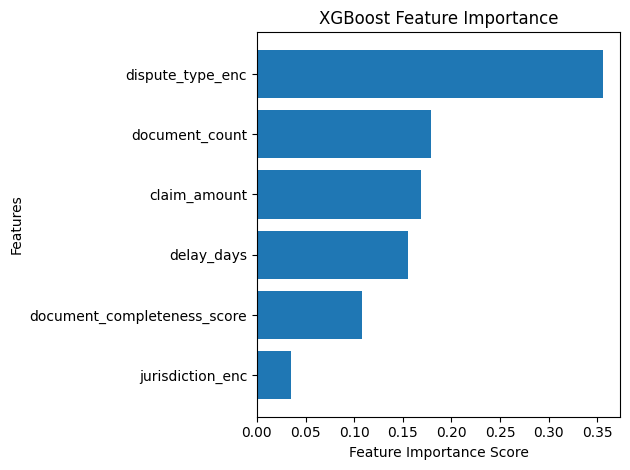

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

importance_df = pd.DataFrame({
    "feature": FEATURES,
    "importance": model.feature_importances_
}).sort_values(by="importance", ascending=True)

plt.figure()
plt.barh(importance_df["feature"], importance_df["importance"])
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("XGBoost Feature Importance")
plt.tight_layout()
plt.savefig("Feature_importance_score.png", dpi=200, bbox_inches="tight")
plt.show()

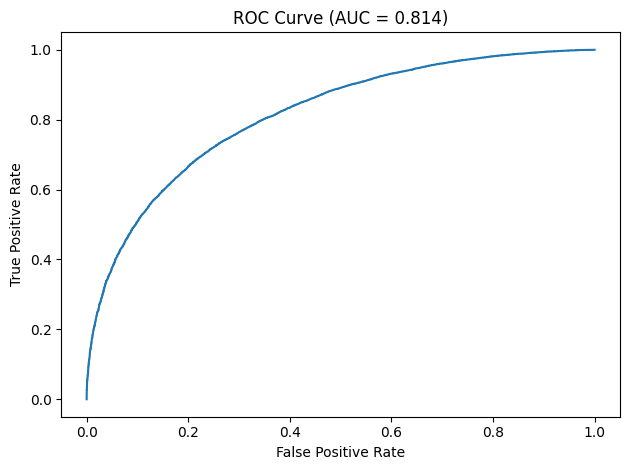

In [11]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc_score = roc_auc_score(y_test, y_prob)

plt.figure()
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve (AUC = {round(auc_score,3)})")
plt.tight_layout()
plt.savefig("Roc_cure.png", dpi=200, bbox_inches="tight")
plt.show()

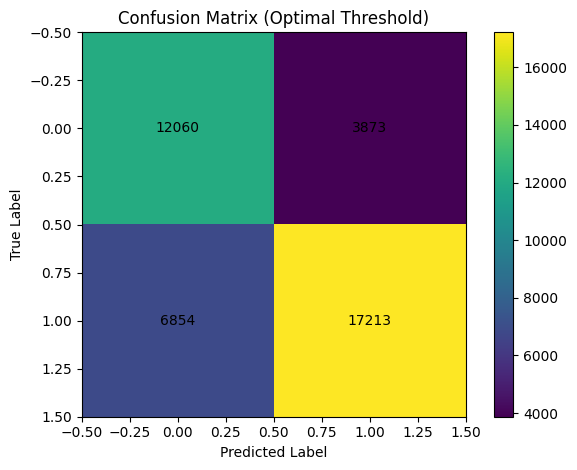

In [13]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

cm = confusion_matrix(y_test, y_pred_opt)

plt.figure()
plt.imshow(cm)
plt.title("Confusion Matrix (Optimal Threshold)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.colorbar()

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.tight_layout()
plt.savefig("Confusion_Matrix.png", dpi=200, bbox_inches="tight")
plt.show()

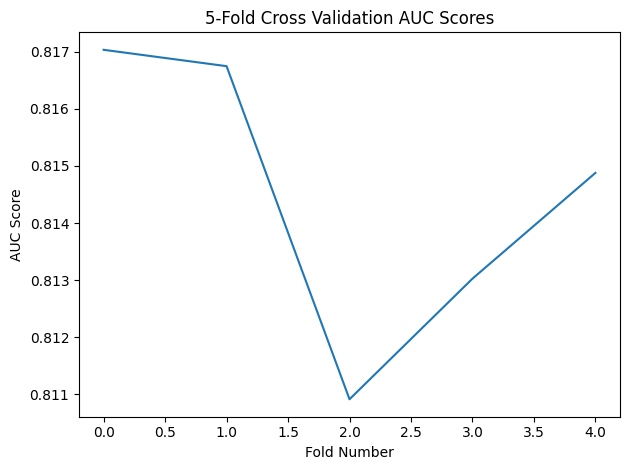

In [14]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(cv_auc)
plt.xlabel("Fold Number")
plt.ylabel("AUC Score")
plt.title("5-Fold Cross Validation AUC Scores")
plt.tight_layout()
plt.savefig("Fold_cross_validation.png", dpi=200, bbox_inches="tight")
plt.show()

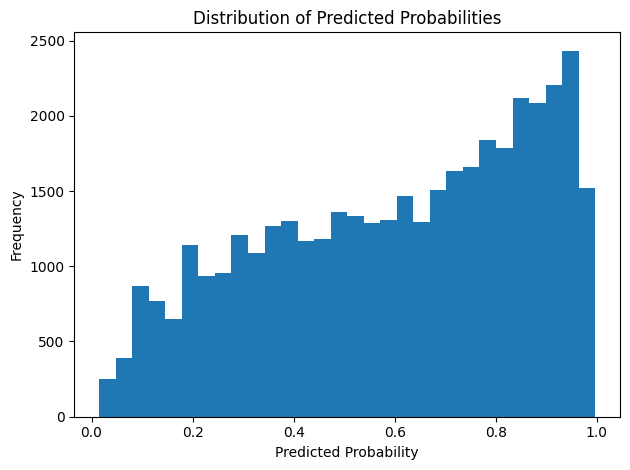

In [15]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(y_prob, bins=30)
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.title("Distribution of Predicted Probabilities")
plt.tight_layout()
plt.savefig("distribution_of_predicted_probabilities.png", dpi=200, bbox_inches="tight")
plt.show()

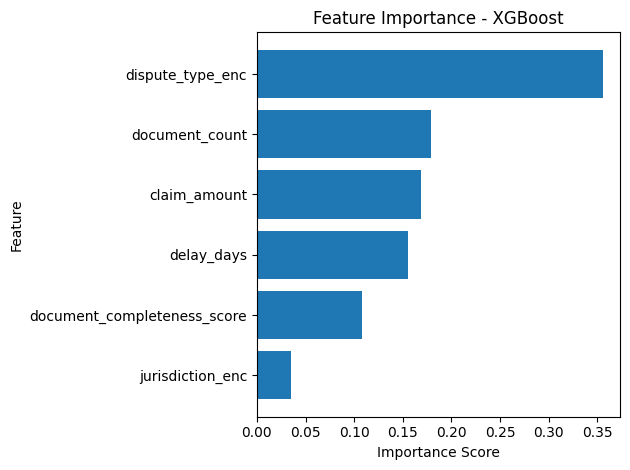

In [13]:
import matplotlib.pyplot as plt
import pandas as pd

importance_df = pd.DataFrame({
    "feature": FEATURES,
    "importance": model.feature_importances_
}).sort_values(by="importance", ascending=True)

plt.figure()
plt.barh(importance_df["feature"], importance_df["importance"])
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Feature Importance - XGBoost")
plt.tight_layout()
plt.show()

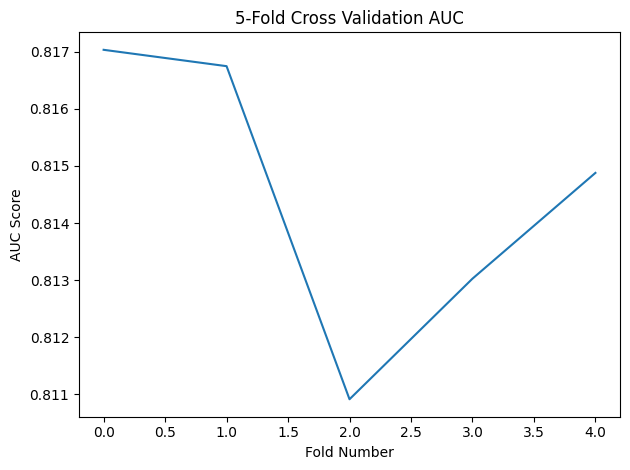

In [14]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(cv_auc)
plt.xlabel("Fold Number")
plt.ylabel("AUC Score")
plt.title("5-Fold Cross Validation AUC")
plt.tight_layout()
plt.show()

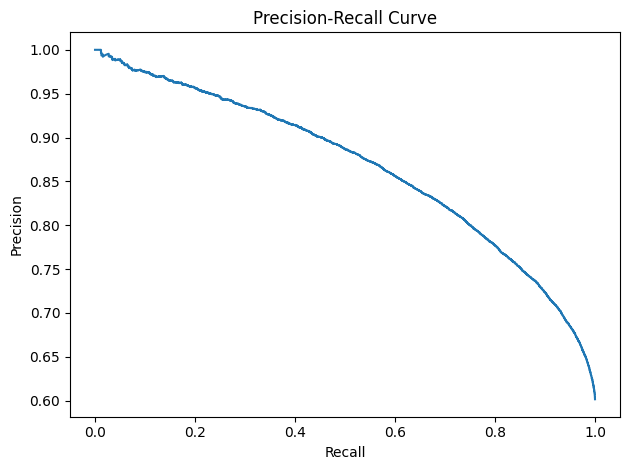

In [16]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, _ = precision_recall_curve(y_test, y_prob)

plt.figure()
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.tight_layout()
plt.savefig("Precison_recall_curve.png", dpi=200, bbox_inches="tight")

plt.show()

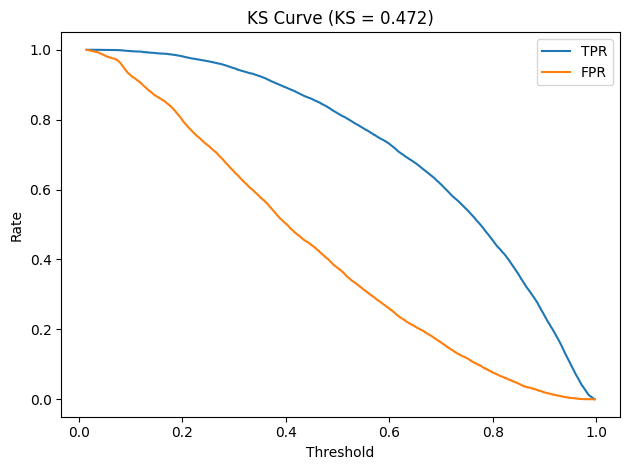

In [16]:
from sklearn.metrics import roc_curve
import numpy as np
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
ks = max(tpr - fpr)

plt.figure()
plt.plot(thresholds, tpr, label="TPR")
plt.plot(thresholds, fpr, label="FPR")
plt.xlabel("Threshold")
plt.ylabel("Rate")
plt.title(f"KS Curve (KS = {round(ks,3)})")
plt.legend()
plt.tight_layout()
plt.show()

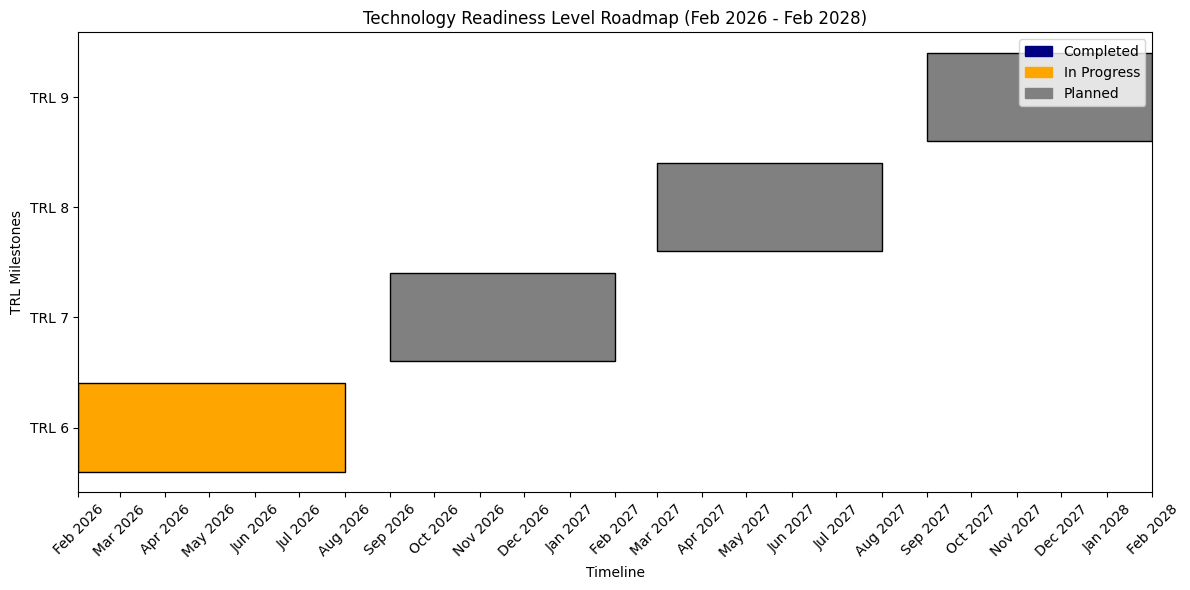

In [1]:
from datetime import datetime, timedelta
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Define TRL milestones and their timelines (assuming example durations)
milestones = [
    {"name": "TRL 6", "start": datetime(2026, 2, 1), "end": datetime(2026, 8, 1), "color": "orange"},  # Amber for in progress
    {"name": "TRL 7", "start": datetime(2026, 9, 1), "end": datetime(2027, 2, 1), "color": "gray"},   # Gray for planned
    {"name": "TRL 8", "start": datetime(2027, 3, 1), "end": datetime(2027, 8, 1), "color": "gray"},   # Gray for planned
    {"name": "TRL 9", "start": datetime(2027, 9, 1), "end": datetime(2028, 2, 1), "color": "gray"}    # Gray for planned
]

# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot each milestone as a horizontal bar
for i, ms in enumerate(milestones):
    ax.barh(ms["name"], (ms["end"] - ms["start"]).days, left=mdates.date2num(ms["start"]), color=ms["color"], edgecolor='black')

# Format x-axis as dates with monthly ticks
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.set_xlim(datetime(2026, 2, 1), datetime(2028, 2, 1))
plt.xticks(rotation=45)

# Labels and title
ax.set_xlabel('Timeline')
ax.set_ylabel('TRL Milestones')
ax.set_title('Technology Readiness Level Roadmap (Feb 2026 - Feb 2028)')

# Add legend
handles = [plt.Rectangle((0,0),1,1, color='navy'), plt.Rectangle((0,0),1,1, color='orange'), plt.Rectangle((0,0),1,1, color='gray')]
ax.legend(handles, ['Completed', 'In Progress', 'Planned'], loc='upper right')

plt.tight_layout()
plt.show()